In [11]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


#train and test data directory
data_dir = "/Users/murunenkhtaivan/Downloads/intel_image_classification/seg_train/seg_train"
test_data_dir = "/Users/murunenkhtaivan/Downloads/intel_image_classification/seg_test/seg_test"


#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [12]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [13]:
print("Follwing classes are there : \n",dataset.classes)


Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Label : buildings


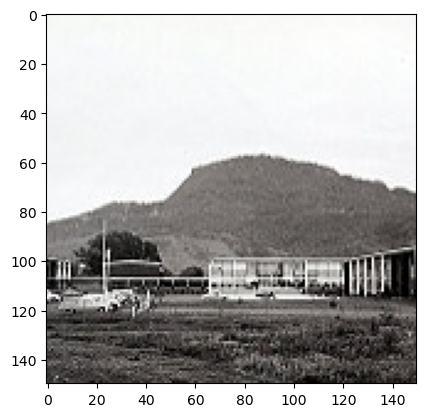

In [14]:
import matplotlib.pyplot as plt

def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [15]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 2000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)


Length of Train Data : 12034
Length of Validation Data : 2000


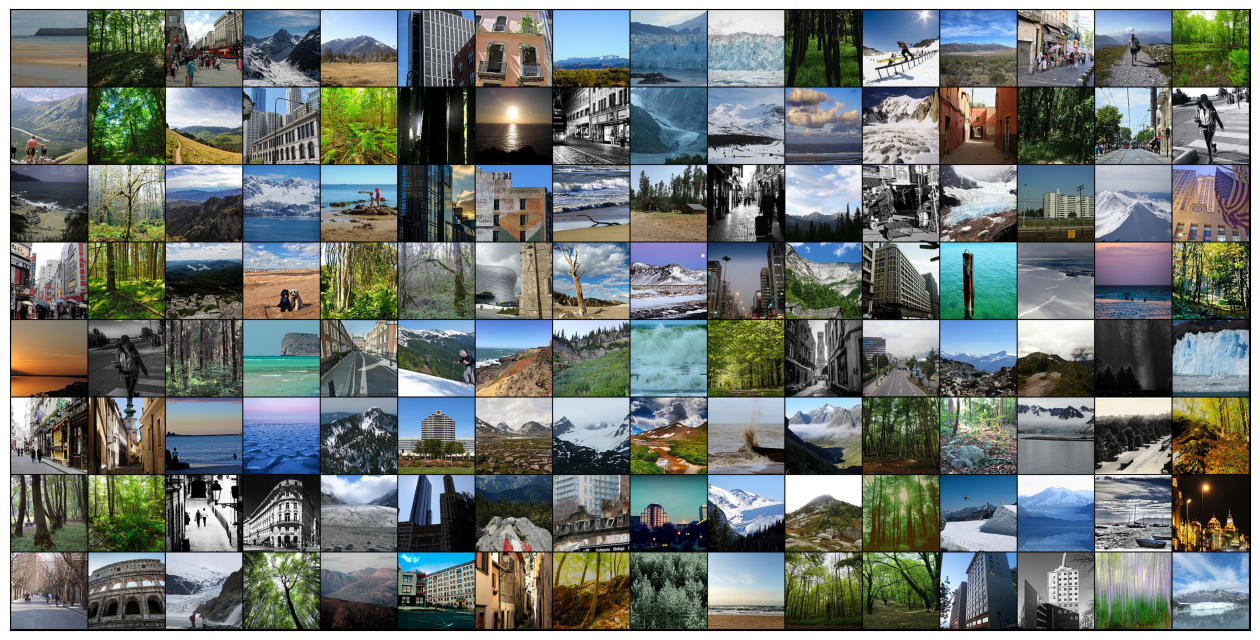

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [17]:
#Base Model - Reusable 
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [18]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        
        # Adjust the input size based on the recalculated feature map size
        self.fc1 = nn.Linear(23120, 50)  # Adjusted input size
        
        self.fc2 = nn.Linear(50, 6)  #Adjust for 6 classes in Intel Image Classification

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.drop(x)
        x = self.pool(x)
        x = F.relu(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
model = NaturalSceneClassification()
model

NaturalSceneClassification(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=23120, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
)

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 150, 150])
out.shape: torch.Size([128, 6])
out[0]: tensor([-1.5730, -1.8620, -1.8498, -1.9071, -1.9029, -1.7021],
       grad_fn=<SelectBackward0>)


In [21]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [22]:
device = get_default_device()
device

device(type='cpu')

In [23]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

NaturalSceneClassification(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=23120, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=6, bias=True)
)

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [25]:
#load the model to the device
model = to_device(NaturalSceneClassification(),device)

In [26]:
#initial evaluation of the model
evaluate(model,val_dl)

{'val_loss': 1.7983795404434204, 'val_acc': 0.1655649095773697}

In [29]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 3
opt_func = torch.optim.Adam
lr = 0.001

In [30]:
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1947, val_loss: 1.0332, val_acc: 0.6062
Epoch [1], train_loss: 1.0327, val_loss: 0.8827, val_acc: 0.6741
Epoch [2], train_loss: 0.9483, val_loss: 0.8147, val_acc: 0.6861


In [31]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8465232849121094, 'val_acc': 0.6758378148078918}

In [32]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = to_device(img.unsqueeze(0), device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

Predicted Class : buildings


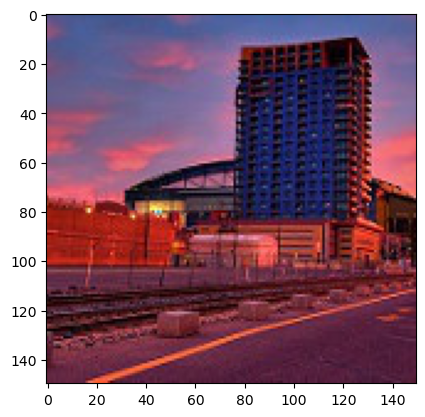

In [34]:
from PIL import Image

#open image file
img = Image.open("/Users/murunenkhtaivan/Downloads/intel_image_classification/seg_pred/seg_pred/350.jpg")

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
plt.imshow(img.permute(1,2,0))

#prdict image label
print(f"Predicted Class : {predict_img_class(img,model)}")